In [2]:
import os
import nibabel as nib
import numpy as np

labels_dir = r"F:\Conditional Latent Diffusion Model for Pancreas\Task07_Pancreas\labelsTr"

tumor_cases = 0
no_tumor_cases = 0
total_cases = 0

for file in os.listdir(labels_dir):
    if file.endswith(".nii.gz") and not file.startswith("._"):
        total_cases += 1
        filepath = os.path.join(labels_dir, file)
        
        label_img = nib.load(filepath)
        label_data = label_img.get_fdata()
        
        if np.any(label_data == 2):
            tumor_cases += 1
        else:
            no_tumor_cases += 1

print(f"Total cases checked: {total_cases}")
print(f"Cases with tumor (label=2): {tumor_cases}")
print(f"Cases without tumor: {no_tumor_cases}")


Total cases checked: 281
Cases with tumor (label=2): 281
Cases without tumor: 0


In [3]:
import os
import nibabel as nib
import numpy as np
labels_dir = r"F:\Conditional Latent Diffusion Model for Pancreas\Task07_Pancreas\labelsTr"


size_bins = {"small": 0, "medium": 0, "large": 0}
case_volumes = {}

for file in os.listdir(labels_dir):
    if file.endswith(".nii.gz") and not file.startswith("._"):
        filepath = os.path.join(labels_dir, file)
        
        # Load label volume
        label_img = nib.load(filepath)
        label_data = label_img.get_fdata()
        
        # Compute voxel spacing in mm
        voxel_volume = np.prod(label_img.header.get_zooms())  # mm³ per voxel
        
        # Tumor volume
        tumor_volume = np.sum(label_data == 2) * voxel_volume
        case_volumes[file] = tumor_volume
        
        # Bin into size category
        if tumor_volume < 20000:  # < ~2 cm
            size_bins["small"] += 1
        elif tumor_volume < 125000:  # 2–5 cm
            size_bins["medium"] += 1
        else:
            size_bins["large"] += 1

print("Tumor size distribution:")
print(size_bins)


Tumor size distribution:
{'small': 255, 'medium': 22, 'large': 4}


In [9]:
import os
import nibabel as nib
import numpy as np
import pandas as pd

labels_dir = r"F:\Conditional Latent Diffusion Model for Pancreas\Task07_Pancreas\labelsTr"
images_dir = r"F:\Conditional Latent Diffusion Model for Pancreas\Task07_Pancreas\imagesTr"

data = []
for file in os.listdir(labels_dir):
    if file.endswith(".nii.gz") and not file.startswith("._"):
        label_path = os.path.join(labels_dir, file)
        image_path = os.path.join(images_dir, file.replace("labelsTr", "imagesTr"))

        # load tumor size
        label_img = nib.load(label_path)
        label_data = label_img.get_fdata()
        voxel_volume = np.prod(label_img.header.get_zooms())
        tumor_volume = np.sum(label_data == 2) * voxel_volume

        if tumor_volume < 20000:
            size_class = "small"
        elif tumor_volume < 125000:
            size_class = "medium"
        else:
            size_class = "large"

        data.append([file, image_path, label_path, tumor_volume, size_class])

df = pd.DataFrame(data, columns=["case", "path_to_image", "path_to_mask", "tumor_volume_mm3", "size_class"])
df.to_csv("pancreas_tumor_sizes.csv", index=False)
print("✅ Saved: pancreas_tumor_sizes.csv")


✅ Saved: pancreas_tumor_sizes.csv


In [10]:
dataset = PancreasDataset("pancreas_tumor_sizes.csv")
print(len(dataset))
sample = dataset[0]
print(sample["image"].shape, sample["label"])


281
(512, 512, 110) 2


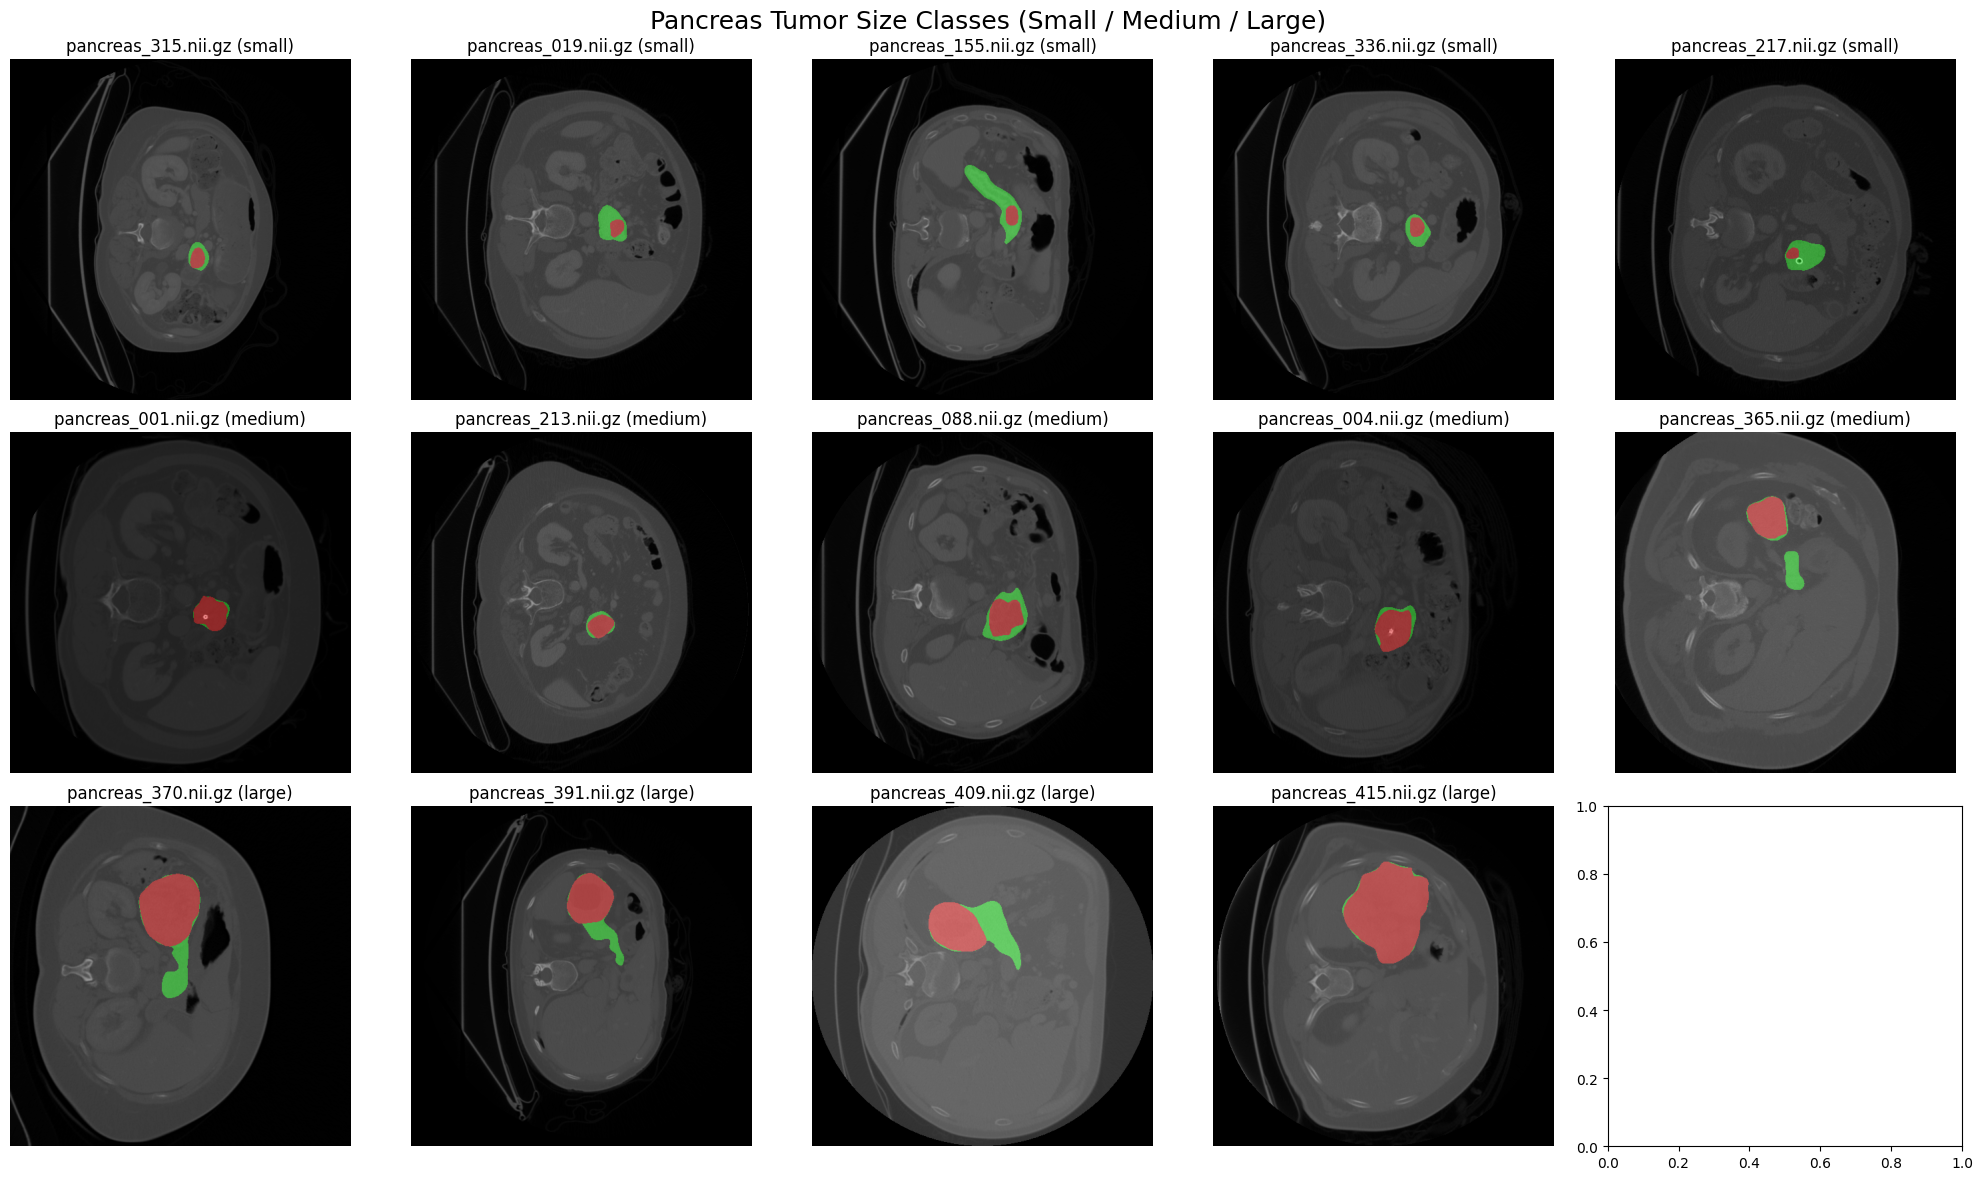

In [15]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load CSV
csv_file = "pancreas_tumor_sizes.csv"
df = pd.read_csv(csv_file)

# Helper: safely sample n or all available
def safe_sample(df, size_class, n, seed=42):
    subset = df[df["size_class"] == size_class]
    if len(subset) < n:
        return subset  # return all if not enough
    return subset.sample(n=n, random_state=seed)

# Select cases
small_cases = safe_sample(df, "small", 5)
medium_cases = safe_sample(df, "medium", 5)
large_cases = safe_sample(df, "large", 5)  # will take 4 automatically

samples = pd.concat([small_cases, medium_cases, large_cases])

# Rows = number of categories, Cols = max per row
rows = 3
cols = max(len(small_cases), len(medium_cases), len(large_cases))

fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

# Ensure axes is always 2D array
axes = np.atleast_2d(axes)

for ax, (_, row) in zip(axes.ravel(), samples.iterrows()):
    image_path = row["path_to_image"]
    mask_path  = row["path_to_mask"]
    size_class = row["size_class"]

    img = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    # Choose slice
    if np.any(mask == 2):
        tumor_voxels = np.where(mask == 2)
        slice_idx = int(np.median(tumor_voxels[2]))
    else:
        slice_idx = img.shape[2] // 2

    slice_img = img[:, :, slice_idx]
    slice_mask = mask[:, :, slice_idx]

    # Normalize
    slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)

    # Overlay
    overlay = np.zeros((*slice_img.shape, 3), dtype=np.uint8)
    overlay[:, :, 0] = (slice_mask == 2) * 255
    overlay[:, :, 1] = (slice_mask == 1) * 255

    ax.imshow(slice_img, cmap="gray")
    ax.imshow(overlay, alpha=0.4)
    ax.set_title(f"{row['case']} ({size_class})")
    ax.axis("off")

plt.suptitle("Pancreas Tumor Size Classes (Small / Medium / Large)", fontsize=18)
plt.tight_layout()
plt.show()


In [22]:
import nibabel as nib
import numpy as np
import plotly.graph_objects as go
from skimage import measure
import pandas as pd
import plotly.io as pio

pio.renderers.default = "browser"

def plot_3d_interactive(mask, title=""):
    fig = go.Figure()

    if np.any(mask == 1):
        verts_p, faces_p, _, _ = measure.marching_cubes(mask == 1, 0.5)
        x_p, y_p, z_p = verts_p.T
        i_p, j_p, k_p = faces_p.T
        fig.add_trace(go.Mesh3d(
            x=x_p, y=y_p, z=z_p,
            i=i_p, j=j_p, k=k_p,
            color='green', opacity=0.3,
            name="Pancreas"
        ))

    if np.any(mask == 2):
        verts_t, faces_t, _, _ = measure.marching_cubes(mask == 2, 0.5)
        x_t, y_t, z_t = verts_t.T
        i_t, j_t, k_t = faces_t.T
        fig.add_trace(go.Mesh3d(
            x=x_t, y=y_t, z=z_t,
            i=i_t, j=j_t, k=k_t,
            color='red', opacity=0.5,
            name="Tumor"
        ))

    
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data"
        ),
        title=title
    )
    
    fig.show()

csv_file = "pancreas_tumor_sizes.csv"
df = pd.read_csv(csv_file)

classes = ["small", "medium", "large"]

for target_class in classes:
    cases = df[df["size_class"] == target_class].head(5) 
    print(f"\nShowing {len(cases)} patients with {target_class} tumors...\n")
    
    for _, row in cases.iterrows():
        mask = nib.load(row["path_to_mask"]).get_fdata()
        plot_3d_interactive(mask, title=f"Patient: {row['case']} ({row['size_class']})")



Showing 5 patients with small tumors...


Showing 5 patients with medium tumors...


Showing 4 patients with large tumors...

